# Notebook für Entwurf von Algorithmen für CAD-System in der Radiologie

Dieses Notebook wird als Experimentelle Umgebung dienen, um diverse Modelle aus dem Computer Vision Bereich von Torch auf ihre Eignung für die Diagnose von Anomalien in Thorax-Röntgenaufnahmen dienen.

Zunächst werden alle für den späteren Verlauf benötigten Bibliotheken importiert.

In [3]:
# Imports von Bibliotheken
import matplotlib.pyplot as plt
import torch
import json
import os
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from collections import OrderedDict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

## Datenimport und Datentransformation

Voraufbereites Datenset aus lokaler Umgebung in das Notebook laden und nach best practice transformieren für den Einsatz für Torchvision Modelle.

In [10]:
#definition der Datenpfade
data_dir = 'Xrays/Data'
train_dir = data_dir + '/Train'
validation_dir = data_dir + '/Validation'
test_dir = data_dir + '/Test'

Übersicht über den Split von Kategorien und Anzahl von Datenpunkten innerhalb des Trainingsdatansatzes

Text(0.5, 1.0, 'Daten nach Kategorie')

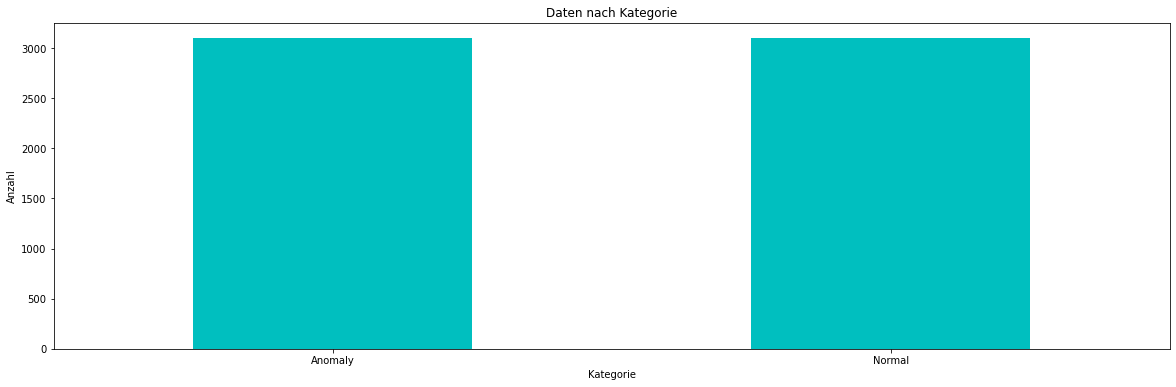

In [12]:
# Erstellen von leeren Listen
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterieren über Kategorien der Daten un Erstellung von DataFrame mit Amzahl nach Kategorie
for d in os.listdir(train_dir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(train_dir + '/' + d)
        valid_imgs = os.listdir(validation_dir + '/' + d)
        test_imgs = os.listdir(test_dir + '/' + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        n_test.append(len(test_imgs))

        # Find stats for train images
        for i in train_imgs:
            if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(train_dir + '/' + d + '/' + i)
                img_array = np.array(img)
                # Shape
                hs.append(img_array.shape[0])
                ws.append(img_array.shape[1])


cat_df = pd.DataFrame({'Kategorie': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('Kategorie')


image_df = pd.DataFrame({
    'Kategorie': img_categories,
    'height': hs,
    'width': ws
})

# Ploten der Ergebnisse
cat_df.set_index('Kategorie')['n_train'].plot.bar(
    color='c', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Anzahl')
plt.title('Daten nach Kategorie')

Import und Transformation der Daten um mit Torch-Algorithmen Kompatibel zu sein.

In [4]:
#Definition von Transformationsregel für Bilder
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])

#laden der Daten
train_data = datasets.ImageFolder(train_dir, transform =train_transforms)
test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)

#transformation der Daten gemäß transformationsregeln
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)

Label mapping nach Import der Daten über angehängtes JSON file um Klassen zuzuweisen Innerhalb des JSONs kodiert 0 für Anomaly und 1 für Normal.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Import von Modellen aus Torchvision

Import von Modellen zur Eignungsprüfung gemäß Aufgabenstellung.
Folgenden Modelle Überprüft:

- vgg16
- resnet50
- densenet161
- googlenet

Darüber hinaus wird ein Anschluss von Neuronen an das bestehende neuronale Netz angefügt, dass der Aufgabenstellung eines Binärklassifikators nachkommt

In [53]:
#import des Models
model_vgg16 = models.vgg16(pretrained=True)

# Einfrieren der Gewichte des vortrainierten Models
for param in model_vgg16.parameters():
    param.requires_grad = False

#Anzeigen der Modelstruktur
print(model_vgg16)

#Ersellen und Anhängen von Klassifikator-Netz gemäß Aufghabenstellung
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 2000)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(2000, 508)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(508, 254)),
                          ('relu', nn.ReLU()),
                          ('fc4', nn.Linear(254, 127)),
                          ('relu', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.2)),
                          ('fc5', nn.Linear(127, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model_vgg16.classifier = classifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
#import des Models
model_res50= models.resnet50(pretrained=True)

# Einfrieren der Gewichte des vortrainierten Models
for param in model_res50.parameters():
    param.requires_grad = False
    
#Anzeigen der Modelstruktur
print(model_res50)

#Ersellen und Anhängen von Klassifikator-Netz gemäß Aufghabenstellung
num_ftrs = model_res50.fc.in_features
model_res50.fc = nn.Linear(num_ftrs, 2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
#import des Models
model_dense161 = models.densenet161(pretrained=True)

# Einfrieren der Gewichte des vortrainierten Models
for param in model_dense161.parameters():
    param.requires_grad = False
    
#Anzeigen der Modelstruktur
print(model_dense161)   

#Ersellen und Anhängen von Klassifikator-Netz gemäß Aufghabenstellung
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2208, 508)),
                          ('relu', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(508, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model_dense161.classifier = classifier

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [50]:
#import des Models
model_google = models.googlenet(pretrained=True)

#Anzeigen der Modelstruktur
print(model_google)

#Ersellen und Anhängen von Klassifikator-Netz gemäß Aufghabenstellung
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 508)),
                          ('relu', nn.ReLU()),
                          ('Dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(508, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model_google.classifier = classifier

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
#Definition der Hardware auf dem die Modelle trainiert werden sollen, 
#aufgrund von nicht cuda-kompatibler GPU und env. 
#Problemen mit reticulate wurde auf cpu ausgewichen
device = "cpu"

Training der Modelle nach train-validation split und Speicherung der Ergebnisse für spätere Arbeiten & Dokumentation

In [56]:
#Erstellen der Trainingsbedingungen und Parameter der Modelle
epochs = 3
hidden_units = 255088 # entfernen für resnet50 / #anpassen gemäß modelstruktur 
dropout = 0.2
steps = 5
running_loss = 0
print_every = 5
learning_rate = 0.001
criterion = nn.NLLLoss() # nn.CrossEntropyLoss() für resnet50
model = model_vgg16
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) # remove .classifier für resnet50 & googlenet
validation_accuracy = []
accuracy_file = 'model_vgg16_datax_accuracy.txt'
model_file = 'model_vgg16_datax.pth'



#Training des Models
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels, model = inputs.to(device), labels.to(device), model.to(device)
        model.train()
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validation_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {validation_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            validation_accuracy.append(accuracy/len(validloader))
            running_loss = 0
            model.train()
torch.save(model, model_file)
with open(accuracy_file, "w") as f:
    for acc in validation_accuracy:
        f.write(str(acc) +"\n")

Epoch 1/3.. Train loss: 3.102.. Validation loss: 0.994.. Validation accuracy: 0.531
Epoch 1/3.. Train loss: 0.647.. Validation loss: 0.575.. Validation accuracy: 0.702
Epoch 1/3.. Train loss: 0.370.. Validation loss: 1.002.. Validation accuracy: 0.652
Epoch 1/3.. Train loss: 0.310.. Validation loss: 0.563.. Validation accuracy: 0.792
Epoch 1/3.. Train loss: 0.205.. Validation loss: 0.607.. Validation accuracy: 0.783
Epoch 1/3.. Train loss: 0.212.. Validation loss: 0.571.. Validation accuracy: 0.790
Epoch 1/3.. Train loss: 0.205.. Validation loss: 0.394.. Validation accuracy: 0.812
Epoch 1/3.. Train loss: 0.259.. Validation loss: 0.424.. Validation accuracy: 0.826
Epoch 2/3.. Train loss: 0.177.. Validation loss: 0.443.. Validation accuracy: 0.835
Epoch 2/3.. Train loss: 0.139.. Validation loss: 0.560.. Validation accuracy: 0.824
Epoch 2/3.. Train loss: 0.167.. Validation loss: 0.413.. Validation accuracy: 0.842
Epoch 2/3.. Train loss: 0.201.. Validation loss: 0.387.. Validation accuracy

## Importieren von traineirten Modellen und Validation Scores

Nachdem nun diversee Modelle trainiert wurden und relevante Ergebnisse anschließend gespeichert wurden. Werden nun basierend auf den Ergebnissen Auswertungen vorgenommen, um zu überprüfen, welche Modelle sich eignen.

In [7]:
#Erstellen von Modellliste für spätere Arbeiten
model_list = ['model_vgg16_trained_val1.pth',
             'model_vgg16_trained_val2.pth',
             'model_vgg16_trained_val3.pth',
             'model_vgg16_trained_val4.pth',
             'model_vgg16_trained_val5.pth',
             'model_res50_trained_val1.pth',
             'model_res50_trained_val2.pth',
             'model_res50_trained_val3.pth',
             'model_res50_trained_val4.pth',
             'model_res50_trained_val5.pth',
             'model_google_trained_val1.pth',
             'model_google_trained_val2.pth',
             'model_google_trained_val3.pth',
             'model_google_trained_val4.pth',
             'model_google_trained_val5.pth',
             'model_dense161_trained_val1.pth',
             'model_dense161_trained_val2.pth',
             'model_dense161_trained_val3.pth',
             'model_dense161_trained_val4.pth',
             'model_dense161_trained_val5.pth']

In [8]:
#Erstellen von Scoreliste für spätere Arbeiten
accuracy_score_list = ['model_vgg16_trained_val1_accuracy.txt',
             'model_vgg16_trained_val2_accuracy.txt',
             'model_vgg16_trained_val3_accuracy.txt',
             'model_vgg16_trained_val4_accuracy.txt',
             'model_vgg16_trained_val5_accuracy.txt',
             'model_res50_trained_val1_accuracy.txt',
             'model_res50_trained_val2_accuracy.txt',
             'model_res50_trained_val3_accuracy.txt',
             'model_res50_trained_val4_accuracy.txt',
             'model_res50_trained_val5_accuracy.txt',
             'model_google_trained_val1_accuracy.txt',
             'model_google_trained_val2_accuracy.txt',
             'model_google_trained_val3_accuracy.txt',
             'model_google_trained_val4_accuracy.txt',
             'model_google_trained_val5_accuracy.txt',
             'model_dense161_trained_val1_accuracy.txt',
             'model_dense161_trained_val2_accuracy.txt',
             'model_dense161_trained_val3_accuracy.txt',
             'model_dense161_trained_val4_accuracy.txt',
             'model_dense161_trained_val5_accuracy.txt']

In [9]:
#import von bereits trainierten modellen
model_trained_list = []

for item in model_list:
    model_file = item
    model_trained_list.append(torch.load(model_file))

In [10]:
#import von bereits validation set accuracy scores
accuracy_scores_list = [[] for i in range(len(accuracy_score_list))]

for ix,i in enumerate(accuracy_score_list):
    score = []
    with open(i, "r") as f:
      for line in f:
        score.append(float(line.strip()))
    accuracy_scores_list[ix].insert(1, score)

## Ploten der Validation Accuracy Scores

Zunächst werden die Trainingsverläufe anhand der Accuracy Scores innerhalb des Traiiningsprozesses geplottet, um einen ersten Einblick in die Qualität der Modelle zu bekommen.

In [10]:
#Erstellen von DataFrames basierend auf Accuracy Scores der ValiationSets
df_val_acc_vgg16 = pd.DataFrame({
    'val_1': accuracy_scores_list[0][0],
    'val_2': accuracy_scores_list[1][0],
    'val_3': accuracy_scores_list[2][0],
    'val_4': accuracy_scores_list[3][0],
    'val_5': accuracy_scores_list[4][0],
}, index = range(0,49))

df_val_acc_res50 = pd.DataFrame({
    'val_1': accuracy_scores_list[5][0],
    'val_2': accuracy_scores_list[6][0],
    'val_3': accuracy_scores_list[7][0],
    'val_4': accuracy_scores_list[8][0],
    'val_5': accuracy_scores_list[9][0],
}, index = range(0,49))

df_val_acc_google = pd.DataFrame({
    'val_1': accuracy_scores_list[10][0],
    'val_2': accuracy_scores_list[11][0],
    'val_3': accuracy_scores_list[12][0],
    'val_4': accuracy_scores_list[13][0],
    'val_5': accuracy_scores_list[14][0],
}, index = range(0,49))

df_val_acc_dense161 = pd.DataFrame({
    'val_1': accuracy_scores_list[15][0],
    'val_2': accuracy_scores_list[16][0],
    'val_3': accuracy_scores_list[17][0],
    'val_4': accuracy_scores_list[18][0],
    'val_5': accuracy_scores_list[19][0],
}, index = range(0,49))

Text(0.5, 1.0, 'Validation Accuracy von DenseNet161')

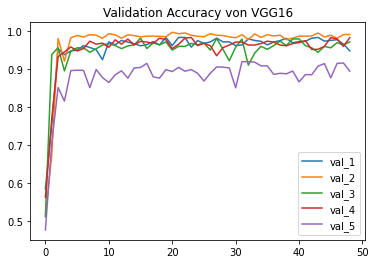

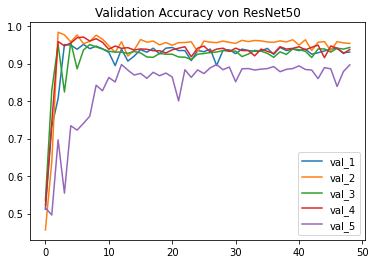

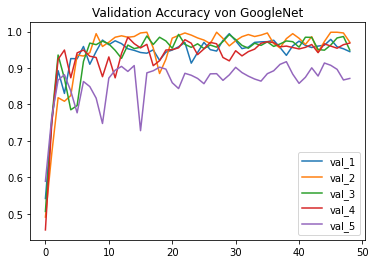

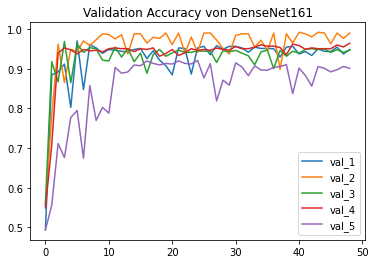

In [12]:
#Plotten der Scores
df_val_acc_vgg16.plot.line()
plt.title('Validation Accuracy von VGG16')
df_val_acc_res50.plot.line()
plt.title('Validation Accuracy von ResNet50')
df_val_acc_google.plot.line()
plt.title('Validation Accuracy von GoogleNet')
df_val_acc_dense161.plot.line()
plt.title('Validation Accuracy von DenseNet161')

## Testen der Modelle

Um die Qualität der Modelle neben dem bereits bestehenden Tests anhand der Validation Scores zu testen, werden ebenfalls Testsets zum Einsatz gebracht. Hierbei ist die generelle Güte der Modelle anhand der Accuracy und die spezifische Güte Anomalien zu identifizieren anhand des Recalls im Fokus. Es werden bewertungen von Test- als auch Validation- set unabhängig voneinader vorgenommen.

In [13]:
#Validierung der Ergebnisse anhand des Testsets

testset_accuracy = []
testset_recall_normal = []
testset_recall_anomaly = []

validationset_accuracy = []
validationset_recall_normal = []
validationset_recall_anomaly = []

#Iteration über bereits traineirte Modelle
for m in range(0,len(model_trained_list)):
    #anpassen der Daten, um nicht auf bereits trainierten Daten zu testen
    if(m == 0 or m == 5 or m == 10 or m == 15):
        data_dir = 'Xrays/CrossValidation1'
        validation_dir = data_dir + '/Validation'
        test_dir = data_dir + '/Test'
        test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])
        test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
        valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)
        validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)
        
    if(m == 1 or m == 6 or m == 11 or m == 16):
        data_dir = 'Xrays/CrossValidation2'
        test_dir = data_dir + '/Test'
        validation_dir = data_dir + '/Validation'
        test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])


        test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
        valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)
        validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)
    if(m == 2 or m == 7 or m == 12 or m == 17):
        data_dir = 'Xrays/CrossValidation3'
        test_dir = data_dir + '/Test'
        validation_dir = data_dir + '/Validation'
        test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])


        test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
        valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)
        validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)
    if(m == 3 or m == 8 or m == 13 or m == 18):
        data_dir = 'Xrays/CrossValidation4'
        test_dir = data_dir + '/Test'
        validation_dir = data_dir + '/Validation'
        test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])


        test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
        valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)
        validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)
    if(m == 4 or m == 9 or m == 14 or m == 19):
        data_dir = 'Xrays/CrossValidation5'
        test_dir = data_dir + '/Test'
        validation_dir = data_dir + '/Validation'
        test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])])


        test_data = datasets.ImageFolder(test_dir, transform =test_valid_transforms)
        testloader = torch.utils.data.DataLoader(test_data, batch_size=500)
        valid_data = datasets.ImageFolder(validation_dir, transform =test_valid_transforms)
        validloader = torch.utils.data.DataLoader(valid_data, batch_size=500)
    model = model_trained_list[m]
    #testen des Testset
    model.eval()
    images, labels = next(iter(testloader))
    # Daten an cpu weitergeben
    images, labels, model = images.to(device), labels.to(device), model.to(device)
    # Klassifikationsergebnisse ausrechnen lassen
    ps = torch.exp(model(images))
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    # Ermitteln von Accuracy und Recall basierend auf Ergebnissen
    print(model_list[m])
    print(f'Testset Accuracy: {accuracy_score(labels,top_class)*100}%')
    print(f'Testset Recall Normal: {recall_score(labels,top_class)*100}%')
    print(f'Testset Recall Anomaly: {(confusion_matrix(labels, top_class)[0][0]/250)*100}%')
    testset_accuracy.append(accuracy_score(labels,top_class)*100)
    testset_recall_normal.append(recall_score(labels,top_class)*100)
    testset_recall_anomaly.append((confusion_matrix(labels, top_class)[0][0]/250)*100)
    
    #testen des Validationset
    model.eval()
    images, labels = next(iter(validloader))
    # Daten an cpu weitergeben
    images, labels, model = images.to(device), labels.to(device), model.to(device)
    # Klassifikationsergebnisse ausrechnen lassen
    ps = torch.exp(model(images))
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    # Ermitteln von Accuracy und Recall basierend auf Ergebnissen
    print(model_list[m])
    print(f'Validationset Accuracy: {accuracy_score(labels,top_class)*100}%')
    print(f'Validationset Recall Normal: {recall_score(labels,top_class)*100}%')
    print(f'Validationset Recall Anomaly: {(confusion_matrix(labels, top_class)[0][0]/250)*100}%')
    validationset_accuracy.append(accuracy_score(labels,top_class)*100)
    validationset_recall_normal.append(recall_score(labels,top_class)*100)
    validationset_recall_anomaly.append((confusion_matrix(labels, top_class)[0][0]/250)*100)
    
test_results = pd.DataFrame(list(zip(model_list, testset_accuracy, testset_recall_normal, testset_recall_anomaly, validationset_accuracy, validationset_recall_normal, validationset_recall_anomaly)), 
                            columns = ['model', 'test_accuracy', 'test_recall_normal', 'test_recall_anomaly', 'validation_accuracy', 'validation_recall_normal', 'validation_recall_anomaly'])
test_results.to_csv('test_results.csv')

model_vgg16_trained_val1.pth
Testset Accuracy: 96.2%
Testset Recall Normal: 94.39999999999999%
Testset Recall Anomaly: 98.0%
model_vgg16_trained_val1.pth
Validationset Accuracy: 94.8%
Validationset Recall Normal: 91.60000000000001%
Validationset Recall Anomaly: 98.0%
model_vgg16_trained_val2.pth
Testset Accuracy: 97.6%
Testset Recall Normal: 99.2%
Testset Recall Anomaly: 96.0%
model_vgg16_trained_val2.pth
Validationset Accuracy: 98.6%
Validationset Recall Normal: 99.6%
Validationset Recall Anomaly: 97.6%
model_vgg16_trained_val3.pth
Testset Accuracy: 93.8%
Testset Recall Normal: 88.0%
Testset Recall Anomaly: 99.6%
model_vgg16_trained_val3.pth
Validationset Accuracy: 97.2%
Validationset Recall Normal: 98.0%
Validationset Recall Anomaly: 96.39999999999999%
model_vgg16_trained_val4.pth
Testset Accuracy: 99.2%
Testset Recall Normal: 99.6%
Testset Recall Anomaly: 98.8%
model_vgg16_trained_val4.pth
Validationset Accuracy: 95.19999999999999%
Validationset Recall Normal: 91.2%
Validationset Re